In [7]:
import sys
import pandas as pd
import numpy as np
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
from csgo.parser import DemoParser
from csgo.parser import FrameParser
pd.options.display.max_columns = None
# Create parser object
# Set log=True above if you want to produce a logfile for the parser
demo_parser = DemoParser(demofile = "DemoManager\Extra Salt\Train\21-04-2021&Dignitas.dem", match_id = "extra-vs-dig")
frame_parser = FrameParser(demofile = "DemoManager\Extra Salt\Train\21-04-2021&Dignitas.dem", match_id = "extra-vs-dig")

# Parse the demofile, output results to dictionary with df name as key
demo_data = demo_parser.parse()
frame_data = frame_parser.parse(df = True)


You should consider upgrading via the 'C:\Users\Ivan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\Ivan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.
00:50:59 [INFO] Initialized CSGODemoParser with demofile DemoManager\Extra Salt\Train-04-2021&Dignitas.dem
00:50:59 [ERROR] Go version too low! Needs 1.14.0


[WinError 2] Не удается найти указанный файл


ValueError: Go version too low! Needs 1.14.0

In [95]:
teams = pd.unique(demo_data["Rounds"]["RoundWinner"])

In [328]:
rounds_t = demo_data["Rounds"][demo_data["Rounds"]["RoundWinnerSide"] == "T"].groupby("RoundWinner").size().reset_index(name="RoundsT")
if len(rounds_t) < 2:
    res_t = next((i for i, x in enumerate(teams) if not x == rounds_t["RoundWinner"][0]), None)
    rounds_t = rounds_t.append(pd.DataFrame({"RoundWinner": [teams[res_t]], "RoundsT" : [0]}),ignore_index=True)
rounds_ct = demo_data["Rounds"][demo_data["Rounds"]["RoundWinnerSide"] == "CT"].groupby("RoundWinner").size().reset_index(name="RoundsCT")
if len(rounds_ct) < 2:
    res_t = next((i for i, x in enumerate(teams) if not x == rounds_ct["RoundWinner"][0]), None)
    rounds_ct = rounds_ct.append(pd.DataFrame({"RoundWinner": [teams[res_t]], "RoundsCT" : [0]}),ignore_index=True)

rounds = rounds_t.merge(rounds_ct,left_on='RoundWinner', right_on='RoundWinner')
rounds

,RoundWinner,RoundsT,RoundsCT
0,BIG,13,3
1,G2 Esports,9,2


In [338]:
def getPlayerInfo (data):
    kill_data = data["Kills"]
    kills =  kill_data.groupby(["AttackerName"]).size().reset_index(name="Kills")
    deaths =  kill_data.groupby(["VictimName"]).size().reset_index(name="Deaths")
    total_rounds = data["Rounds"].shape[0]
    kills["Entries"] = np.zeros(kills.shape[0],dtype=int)
    for ind,kill in enumerate(kill_data["RoundNum"], start=0):
        if (ind == 0) :
            kills.loc[kills["AttackerName"] == kill_data["AttackerName"][ind], "Entries"] += 1
            continue
        if (kill_data["RoundNum"][ind - 1] != kill_data["RoundNum"][ind]):
            kills.loc[kills["AttackerName"] == kill_data["AttackerName"][ind], "Entries"] += 1
            continue
        kills= kills[kills["AttackerName"] != "NA"] 
    # Add Armor damage to the HP damage for each damage entry to get total damage
    data["Damages"]["HpDamageArmor"] = data["Damages"]["HpDamage"] + data["Damages"]["ArmorDamage"]
    data["Damages"]["KillHpDamageArmor"] = data["Damages"]["KillHpDamage"] + data["Damages"]["ArmorDamage"]
    #Perctange headshots 
    head_per = data["Kills"].groupby("AttackerName").IsHeadshot.mean().reset_index(name="HeadShotPct")
    # Calculate
    adr = (data["Damages"].groupby(["AttackerName"])["HpDamageArmor", "KillHpDamageArmor"].sum()/total_rounds).reset_index()
    adr.columns = ["PlayerName", "RawADR", "NormADR"]
    adr = adr[adr["PlayerName"] != "NA"]
    final_data = kills.merge(deaths, left_on="AttackerName", right_on="VictimName").merge(adr, left_on="VictimName", right_on ="PlayerName")
    final_data = final_data.merge(head_per,left_on="AttackerName", right_on="AttackerName" )
    final_data = final_data[["PlayerName", "Kills", "Deaths", "NormADR","HeadShotPct", "Entries"]]
    return final_data
getPlayerInfo(demo_data)
# smoke_thrown = data["Grenades"][data["Grenades"]["GrenadeType"].isin(["Smoke"])].groupby("PlayerName").size().reset_index(name="SmokeThrown")
# # You can also write the demofile data to JSON using
# smoke_thrown
# demo_data["Kills"]
# list(filter(lambda x: x > 1, demo_data["Kills"]["RoundNum"]))


<ipython-input-338-234c69300b2b>:21: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  adr = (data["Damages"].groupby(["AttackerName"])["HpDamageArmor", "KillHpDamageArmor"].sum()/total_rounds).reset_index()


,PlayerName,Kills,Deaths,NormADR,HeadShotPct,Entries
0,AMANEK,22,18,133.407407,0.681818,2
1,JACKZ,13,20,83.074074,0.538462,1
2,XANTARES,18,18,98.555556,0.555556,3
3,huNter,26,20,134.481481,0.576923,2
4,k1to,19,20,117.296296,0.631579,2
5,kennyS,17,22,79.925926,0.235294,1
6,nexa,13,22,89.592593,0.615385,2
7,syrsoN,27,17,118.148148,0.370370,9
8,tabseN,19,18,97.703704,0.368421,1
9,tiziaN,18,18,90.592593,0.611111,4


In [330]:
# Считаем количество поставленных бомб на разные планты 
plant_a = demo_data["BombEvents"][demo_data["BombEvents"]["EventType"] == "Plant"][demo_data["BombEvents"]["BombSite"] == "A"].groupby("Team").size().reset_index(name="PlantOnA")
plant_b = demo_data["BombEvents"][demo_data["BombEvents"]["EventType"] == "Plant"][demo_data["BombEvents"]["BombSite"] == "B"].groupby("Team").size().reset_index(name="PlantOnB")
# Если на а или б ни разу не поставили бомбу
if plant_a.empty or plant_b.empty:
    plants_a = pd.DataFrame({'Team': teams, 'PlantOnA': [0,0]}) if plant_a.empty else plants_a
    plants_b =  pd.DataFrame({'Team': teams, 'PlantOnB': [0,0]})if plant_b.empty else plants_b
# Если какая-либо из команд не поставила ни разу бомбу на плант а или б
if len(plant_a) < 2 :
    res_t = next((i for i, x in enumerate(teams) if not x == plant_a["Team"][0]), None)
    plants_a = plants_a.append(pd.DataFrame({"Team": [teams[res_t]], "PlantOnA" : [0]}),ignore_index=True)
if len(plant_b) < 2 :
    res_t = next((i for i, x in enumerate(teams) if not x == plant_b["Team"][0]), None)
    plants_b = plants_b.append(pd.DataFrame({"Team": [teams[res_t]], "PlantOnB" : [0]}),ignore_index=True)
plants = plant_a.merge(plant_b, left_on="Team", right_on="Team")

defuses_a = demo_data["BombEvents"][demo_data["BombEvents"]["EventType"] == "Defuse"][demo_data["BombEvents"]["BombSite"] == "A"].groupby("Team").size().reset_index(name="DefuseOnA")
defuses_b = demo_data["BombEvents"][demo_data["BombEvents"]["EventType"] == "Defuse"][demo_data["BombEvents"]["BombSite"] == "B"].groupby("Team").size().reset_index(name="DefuseOnB")
if defuses_a.empty or defuses_b.empty:
    defuses_a = pd.DataFrame({'Team': teams, 'DefuseOnA': [0,0]}) if defuses_a.empty else defuses_a
    defuses_b = pd.DataFrame({'Team': teams, 'DefuseOnB': [0,0]}) if defuses_b.empty else defuses_b
# Если какая-либо из команд не задифьюзела ни разу бомбу на а или б
if len(defuses_a) < 2 :
    res_t = next((i for i, x in enumerate(teams) if not x == defuses_a["Team"][0]), None)
    defuses_a = defuses_a.append(pd.DataFrame({"Team": [teams[res_t]], "DefuseOnA" : [0]}),ignore_index=True)
if len(defuses_b) < 2 :
    res_t = next((i for i, x in enumerate(teams) if not x == defuses_b["Team"][0]), None)
    defuses_b = defuses_b.append(pd.DataFrame({"Team": [teams[res_t]], "DefuseOnB" : [0]}),ignore_index=True)
plants = plant_a.merge(plant_b, left_on="Team", right_on="Team")
defuses = defuses_a.merge(defuses_b, left_on="Team", right_on="Team")


rounds_bombs = plants.merge(defuses, left_on="Team", right_on="Team")
rounds_bombs["SucPercA"] = (rounds_bombs["PlantOnA"] - rounds_bombs["DefuseOnA"].iloc[::-1].values) / rounds_bombs["PlantOnA"]
rounds_bombs["SucPercB"] = (rounds_bombs["PlantOnB"] - rounds_bombs["DefuseOnB"].iloc[::-1].values) / rounds_bombs["PlantOnB"]
rounds_bombs
clear = demo_data["Rounds"][demo_data["Rounds"]["Reason"].isin(["CTWin", "TargetSaved"])].groupby("RoundWinner").size().reset_index(name="ClearRoundsCT")
if clear.empty:
    clear = pd.DataFrame({'Team': teams, 'ClearRoundsCT': [0,0]})
else:
    if len(clear["RoundWinner"]) < 2:
        res_t = next((i for i, x in enumerate(teams) if not x == clear["RoundWinner"][0]), None)
        clear = clear.append(pd.DataFrame({"RoundWinner": [teams[res_t]], "ClearRoundsCT" : [0]}),ignore_index=True)
clear.columns = ["Team","ClearRoundsCT"]
rounds_bombs = rounds_bombs.merge(clear, left_on="Team", right_on="Team")
rounds_bombs





<ipython-input-330-05394253a8d5>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plant_a = demo_data["BombEvents"][demo_data["BombEvents"]["EventType"] == "Plant"][demo_data["BombEvents"]["BombSite"] == "A"].groupby("Team").size().reset_index(name="PlantOnA")
<ipython-input-330-05394253a8d5>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plant_b = demo_data["BombEvents"][demo_data["BombEvents"]["EventType"] == "Plant"][demo_data["BombEvents"]["BombSite"] == "B"].groupby("Team").size().reset_index(name="PlantOnB")
<ipython-input-330-05394253a8d5>:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  defuses_a = demo_data["BombEvents"][demo_data["BombEvents"]["EventType"] == "Defuse"][demo_data["BombEvents"]["BombSite"] == "A"].groupby("Team").size().reset_index(name="DefuseOnA")
<ipython-input-330-05394253a8d5>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  d

,Team,PlantOnA,PlantOnB,DefuseOnA,DefuseOnB,SucPercA,SucPercB,ClearRoundsCT
0,BIG,10,5,2,0,0.800000,1.0,1
1,G2 Esports,6,2,2,0,0.666667,1.0,0


In [1]:
smoke_thrown = demo_data["Grenades"][demo_data["Grenades"]["GrenadeType"].isin(["Smoke"])].groupby("Team").size().reset_index(name="Smoke")
flash_thrown_ct = demo_data["Grenades"][demo_data["Grenades"]["GrenadeType"].isin(["Flash"])][demo_data["Grenades"]["Side"] == "CT"].groupby("Team").size().reset_index(name="FlashCT")
flash_thrown_t = demo_data["Grenades"][demo_data["Grenades"]["GrenadeType"].isin(["Flash"])][demo_data["Grenades"]["Side"] == "T"].groupby("Team").size().reset_index(name="FlashT")
#smoke_thrown.div(2)
smoke_thrown["Smoke"] = round(smoke_thrown["Smoke"] / 2)
smoke_thrown
grenades = smoke_thrown.join(flash_thrown_ct, lsuffix='', rsuffix='_other')
grenades = grenades.merge(flash_thrown_t,left_on='Team', right_on="Team")
flashes_avg_ct = flash_thrown_ct["FlashCT"] / (rounds["RoundsCT"][0] + rounds["RoundsT"][1])
flashes_avg_t = flash_thrown_t["FlashT"] / (rounds["RoundsCT"][1] + rounds["RoundsT"][0])
nade_dmg_df = nade_dmg.groupby("AttackerTeam").HpDamage.sum().reset_index(name="UtilityDamage").sort_values("UtilityDamage", ascending=False)
grenades = grenades.merge(nade_dmg_df, left_on='Team', right_on='AttackerTeam')
grenades["AvgFlashesCT"] = flashes_avg_ct
grenades["AvgFlashesT"] = flashes_avg_t
grenades = grenades [["Team", "Smoke", "FlashCT","AvgFlashesCT", "FlashT", "AvgFlashesT", "UtilityDamage"]]
grenades

NameError: name 'demo_data' is not defined

In [332]:
demo_data["Damages"][demo_data["Damages"]["Weapon"] == "Flash"]

,MatchId,MapName,RoundNum,Tick,Second,VictimX,VictimY,VictimZ,VictimXViz,VictimYViz,VictimViewX,VictimViewY,VictimAreaId,VictimAreaName,AttackerX,AttackerY,AttackerZ,AttackerXViz,AttackerYViz,AttackerViewX,AttackerViewY,AttackerAreaId,AttackerAreaName,VictimSteamId,VictimName,VictimTeam,VictimSide,VictimTeamEqVal,AttackerSteamId,AttackerName,AttackerTeam,AttackerSide,AttackerTeamEqVal,HpDamage,KillHpDamage,ArmorDamage,Weapon,HitGroup,HpDamageArmor,KillHpDamageArmor
465,big-vs-g2-dust,de_dust2,17,332657,67.875,821.851135,2609.910889,94.848053,749.511622,-142.974798,211.821899,2.15332,1724,BombsiteA,1289.51001,2538.87915,127.03125,855.797729,-159.118375,211.668091,1.576538,8990,BombsiteA,76561197972242917,JACKZ,G2 Esports,T,19700,76561197961491680,tabseN,BIG,CT,10650,1,1,0,Flash,NA,1,1


In [336]:
rounds

,RoundWinner,RoundsT,RoundsCT
0,BIG,13,3
1,G2 Esports,9,2


In [39]:
df = demo_parser.parse(df = True)

TypeError: parse() got an unexpected keyword argument 'df'

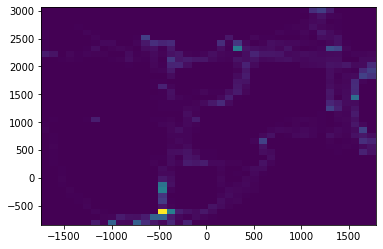

In [92]:

import matplotlib.pyplot as plt
ticks = frame_data.sort_values(by=['Tick'])
ticks = ticks [ticks["Hp"] > 0]
ticks = ticks[ticks["TicksSinceStart"] != '0']
playersPos = ticks[['PlayerName','X', 'Y']].groupby('PlayerName').agg(list)
plt.hist2d(playersPos["X"]["syrsoN"],playersPos["Y"]["syrsoN"],bins=40)

plt.show()

In [61]:
playersPos

,X,Y
PlayerName,,
AMANEK,"[160.123001, 160.123001, 160.123001, 160.12300...","[2369.679932, 2369.679932, 2369.679932, 2369.6..."
JACKZ,"[182.25, 182.25, 182.25, 182.25, 182.25, 182.2...","[2439.01001, 2439.01001, 2439.01001, 2439.0100..."
XANTARES,"[-428.0, -428.0, -428.0, -428.0, -428.0, -428....","[-843.0, -843.0, -843.0, -843.0, -843.0, -843...."
huNter,"[334.368988, 334.368988, 334.368988, 334.36898...","[2433.72998, 2433.72998, 2433.72998, 2433.7299..."
k1to,"[-332.0, -332.0, -332.0, -332.0, -332.0, -332....","[-754.0, -754.0, -754.0, -754.0, -754.0, -754...."
kennyS,"[351.391998, 351.391998, 351.391998, 351.39199...","[2352.939941, 2352.939941, 2352.939941, 2352.9..."
nexa,"[258.158997, 258.158997, 258.158997, 258.15899...","[2480.550049, 2480.550049, 2480.550049, 2480.5..."
syrsoN,"[-857.5070189999999, -857.5070189999999, -857....","[-738.361023, -738.361023, -738.361023, -738.3..."
tabseN,"[-533.0, -533.0, -533.0, -533.0, -533.0, -533....","[-754.0, -754.0, -754.0, -754.0, -754.0, -754...."


In [111]:
def count_streak():
    round_streaks = {teams[0]: [], teams[1] : []}
    winner_round = ''
    count = 0
    for ind, win in enumerate(demo_data["Rounds"]["RoundWinner"]):
        if (ind == 0):
            winner_round = demo_data["Rounds"]["RoundWinner"][0]
            count +=1 
        else:
            if (winner_round != demo_data["Rounds"]["RoundWinner"][ind]):
                round_streaks[winner_round].append(count)
                count = 1
                winner_round = demo_data["Rounds"]["RoundWinner"][ind]
            else: 
                count+=1
    return round_streaks

count_streak()

{'BIG': [7, 2, 4, 1], 'G2 Esports': [1, 1, 5, 4]}